# Estandarizacion de los datos de entrada del PIB a Precios Constantes

## Dependencias

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime, date, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Formato inicial de los datos

### Cargue de los datos

In [3]:
BASE_DIR = './data/input'
OUTPUT_DIR = './data/output'

In [4]:
# Archivo obtenido del DANE
# Acceso: https://www.dane.gov.co/index.php/estadisticas-por-tema/cuentas-nacionales/cuentas-nacionales-departamentales 
XLSX_FILENAME = f'{BASE_DIR}/anexo-2020-provisional-PIB-total-por-departamento.xlsx'
XLSX_SHEET = "export"

# Archivo obtenido del banco de la república
# Acceso: https://totoro.banrep.gov.co/analytics/saw.dll?Portal
CSV_FILENAME = f'{BASE_DIR}/Producto Interno Bruto_PIB_Grafica.csv'

In [5]:
xlsx = pd.read_excel(XLSX_FILENAME, sheet_name=XLSX_SHEET)
csv = pd.read_csv(CSV_FILENAME, sep=",")

### Renombrar columnas

In [6]:
def parse_columns(column):
    if column == 'Código Departamento (DIVIPOLA)':
        column = 'CODIGO_DEPARTAMENTO'
    return str(column).lower().replace('s', '')

In [7]:
csv.columns = csv.columns.to_series().apply(parse_columns)
csv.columns

Index(['decripción nivel 1', 'variación anual', 'producto interno bruto (pib)',
       'id concepto', 'id trimetre'],
      dtype='object')

In [8]:
xlsx.columns = xlsx.columns.to_series().apply(parse_columns)
xlsx.columns

Index(['codigo_departamento', 'departamento', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020'],
      dtype='object')

### Reemplazar valores nulos

In [9]:
xlsx['codigo_departamento'] = xlsx['codigo_departamento'].fillna(0)
xlsx.head(40)

,codigo_departamento,departamento,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0.0,COLOMBIA,514853.000000,549435.000000,586457.000000,605713.000000,612616.000000,640151.000000,684628.000000,711415.000000,747939.000000,781589.000000,804692.000000,821489.000000,832656.000000,854008.000000,881224.000000,819114.000000
1,91.0,Amazonas,413.007446,432.519609,442.275690,456.909813,469.917921,486.178057,500.812179,520.324342,541.462518,562.600694,593.364403,613.629086,629.735963,648.349034,665.761032,615.341532
2,5.0,Antioquia,73922.532786,79223.681846,84784.032893,86215.889649,85660.010691,88492.495048,95753.273585,99628.811719,104011.823623,111128.948046,115446.256983,119046.384115,120973.266580,125172.956751,129671.980682,121299.887817
3,81.0,Arauca,5044.233001,5101.916075,5537.575079,5778.933204,5768.307374,5284.073150,5077.628465,4819.572609,4672.328973,4309.532799,4534.093020,4271.820897,4167.627336,4293.332305,4596.268607,4565.372851
4,8.0,Atlántico,22121.967036,23862.690923,26106.040803,26748.374341,26735.527670,26632.754304,28126.179779,30066.027063,31663.831738,33772.291575,35716.295690,36347.380065,36779.304587,37609.645977,38689.993707,36173.033590
5,11.0,Bogotá D.C.,135214.860000,144141.327225,153258.830699,158292.934352,161609.204236,167408.945355,176869.717089,183103.767181,190160.168625,198995.595138,206478.408916,210682.968931,214483.690052,221651.988154,229313.761785,214485.169839
6,13.0,Bolívar,18885.522452,20196.091190,21861.251037,22152.015746,22106.628084,23076.789358,25158.948349,25784.447064,28346.013234,27792.851104,28105.211288,29284.661306,30271.190344,30804.088276,31919.755993,28623.050059
7,15.0,Boyacá,13069.081142,13693.987327,15466.802714,16572.751789,16725.606539,17346.016996,18968.974784,19556.416570,20127.374019,20986.058057,22164.683373,22341.244463,22574.436275,23236.707775,23732.383798,21709.124855
8,17.0,Caldas,9411.269444,10153.804135,10745.287871,10926.549015,10424.105842,10675.327429,10695.997559,10777.088071,11462.382400,12106.336467,12513.501745,12821.068784,13043.346698,13394.763407,13798.051821,13173.668463
9,18.0,Caquetá,2088.258973,2172.860957,2336.424793,2460.507703,2543.699654,2573.310348,2663.552465,2982.219938,3155.654005,3323.447940,3349.867477,3426.809505,3453.897097,3525.116077,3595.866331,3386.610065


### Crear Dataframe de salida

In [10]:
output_columns = ['AAAA', 'TRIMESTRE', 'DEPARTAMENTO', 'PIB_COLOMBIA_ANUAL', 'PIB_COLOMBIA_TRIMESTRAL', 'PIB_DEPARTAMENTO_ANUAL', 'APORTE', 'PIB_DEPARTAMENTAL_TRIMESTRAL']
PIB_provisional = pd.DataFrame(columns=output_columns)

In [11]:
AMOUNT_OF_DEPARTMENTS, _ = xlsx.shape

# Deberiamos tener 33 departamentos ya que tenemos que excluir a COLOMBIA.
AMOUNT_OF_DEPARTMENTS = AMOUNT_OF_DEPARTMENTS - 1 
AMOUNT_OF_DEPARTMENTS

33

In [12]:
AMOUNT_OF_TRIMESTERS = 4
AMOUNT_OF_YEARS = len(xlsx.columns[2:])

#### Columna AAAA

In [13]:
raw_years = xlsx.columns[2:]
years = np.repeat(np.repeat(raw_years, AMOUNT_OF_DEPARTMENTS), AMOUNT_OF_TRIMESTERS)

#### Columna TRIMESTRE

In [14]:
trimesters = np.tile(np.tile(np.arange(AMOUNT_OF_TRIMESTERS) + 1, AMOUNT_OF_DEPARTMENTS), AMOUNT_OF_YEARS)

#### Columna DEPARTAMENTO

In [15]:
departments_unique = xlsx['departamento'].iloc[1:].apply(str.lower).to_list()
departments = np.tile(np.repeat(departments_unique, AMOUNT_OF_TRIMESTERS), AMOUNT_OF_YEARS)
departments.shape

(2112,)

#### Asignación inicial del dataframe

In [16]:
departments_metadata = np.dstack((years, trimesters, departments))[0]

In [17]:
PIB_provisional[['AAAA', 'TRIMESTRE', 'DEPARTAMENTO']] = pd.DataFrame(departments_metadata)

In [18]:
ROW_AMOUNT = len(PIB_provisional)
ROW_AMOUNT

2112

#### Columna PIB_COLOMBIA_ANUAL

In [19]:
colombia_yearly_pib = np.repeat(np.repeat(xlsx.iloc[0, :].to_list()[2:], AMOUNT_OF_DEPARTMENTS), AMOUNT_OF_TRIMESTERS)
print(np.min(colombia_yearly_pib))
PIB_provisional['PIB_COLOMBIA_ANUAL'] = colombia_yearly_pib

514853.0


#### Columna PIB_DEPARTAMENTO_ANUAL

Primero verificamos el PIB a precios constantes por departamento con perodicidad anual obtenidos del DANE:

In [20]:
xlsx.iloc[0:, 1:]

,departamento,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,COLOMBIA,514853.000000,549435.000000,586457.000000,605713.000000,612616.000000,640151.000000,684628.000000,711415.000000,747939.000000,781589.000000,804692.000000,821489.000000,832656.000000,854008.000000,881224.000000,819114.000000
1,Amazonas,413.007446,432.519609,442.275690,456.909813,469.917921,486.178057,500.812179,520.324342,541.462518,562.600694,593.364403,613.629086,629.735963,648.349034,665.761032,615.341532
2,Antioquia,73922.532786,79223.681846,84784.032893,86215.889649,85660.010691,88492.495048,95753.273585,99628.811719,104011.823623,111128.948046,115446.256983,119046.384115,120973.266580,125172.956751,129671.980682,121299.887817
3,Arauca,5044.233001,5101.916075,5537.575079,5778.933204,5768.307374,5284.073150,5077.628465,4819.572609,4672.328973,4309.532799,4534.093020,4271.820897,4167.627336,4293.332305,4596.268607,4565.372851
4,Atlántico,22121.967036,23862.690923,26106.040803,26748.374341,26735.527670,26632.754304,28126.179779,30066.027063,31663.831738,33772.291575,35716.295690,36347.380065,36779.304587,37609.645977,38689.993707,36173.033590
5,Bogotá D.C.,135214.860000,144141.327225,153258.830699,158292.934352,161609.204236,167408.945355,176869.717089,183103.767181,190160.168625,198995.595138,206478.408916,210682.968931,214483.690052,221651.988154,229313.761785,214485.169839
6,Bolívar,18885.522452,20196.091190,21861.251037,22152.015746,22106.628084,23076.789358,25158.948349,25784.447064,28346.013234,27792.851104,28105.211288,29284.661306,30271.190344,30804.088276,31919.755993,28623.050059
7,Boyacá,13069.081142,13693.987327,15466.802714,16572.751789,16725.606539,17346.016996,18968.974784,19556.416570,20127.374019,20986.058057,22164.683373,22341.244463,22574.436275,23236.707775,23732.383798,21709.124855
8,Caldas,9411.269444,10153.804135,10745.287871,10926.549015,10424.105842,10675.327429,10695.997559,10777.088071,11462.382400,12106.336467,12513.501745,12821.068784,13043.346698,13394.763407,13798.051821,13173.668463
9,Caquetá,2088.258973,2172.860957,2336.424793,2460.507703,2543.699654,2573.310348,2663.552465,2982.219938,3155.654005,3323.447940,3349.867477,3426.809505,3453.897097,3525.116077,3595.866331,3386.610065


Luego obtenemos los valores de las filas:

In [21]:
pib_data = xlsx.iloc[1:, 2:]
pib_data.values

array([[4.13007446e+02, 4.32519609e+02, 4.42275690e+02, 4.56909813e+02,
        4.69917921e+02, 4.86178057e+02, 5.00812179e+02, 5.20324342e+02,
        5.41462518e+02, 5.62600694e+02, 5.93364403e+02, 6.13629086e+02,
        6.29735963e+02, 6.48349034e+02, 6.65761032e+02, 6.15341532e+02],
       [7.39225328e+04, 7.92236818e+04, 8.47840329e+04, 8.62158896e+04,
        8.56600107e+04, 8.84924950e+04, 9.57532736e+04, 9.96288117e+04,
        1.04011824e+05, 1.11128948e+05, 1.15446257e+05, 1.19046384e+05,
        1.20973267e+05, 1.25172957e+05, 1.29671981e+05, 1.21299888e+05],
       [5.04423300e+03, 5.10191608e+03, 5.53757508e+03, 5.77893320e+03,
        5.76830737e+03, 5.28407315e+03, 5.07762847e+03, 4.81957261e+03,
        4.67232897e+03, 4.30953280e+03, 4.53409302e+03, 4.27182090e+03,
        4.16762734e+03, 4.29333231e+03, 4.59626861e+03, 4.56537285e+03],
       [2.21219670e+04, 2.38626909e+04, 2.61060408e+04, 2.67483743e+04,
        2.67355277e+04, 2.66327543e+04, 2.81261798e+04, 3.006

Finalmente concatenamos los valores por año y repetimos cada valor por cada trimestre:

In [22]:
department_yearly_pib = np.repeat(pib_data.values.flatten('F'), AMOUNT_OF_TRIMESTERS)
print(np.min(department_yearly_pib))
PIB_provisional['PIB_DEPARTAMENTO_ANUAL'] = department_yearly_pib

137.34783378304203


#### Columna APORTE

Para esta columna solo calculamos el aporte de un departamento de forma anual siguiendo la formula:
    
$$\% \text{Aporte} = \frac{\text{PIB Departamental Anual}}{\text{PIB Anual Nivel País}}$$

In [23]:
PIB_provisional['APORTE'] = PIB_provisional['PIB_DEPARTAMENTO_ANUAL'] / PIB_provisional['PIB_COLOMBIA_ANUAL']

#### Columna PIB_COLOMBIA_TRIMESTRAL

Para esta columna nos apoyamos en los datos obtenidos del banco de la república:

In [24]:
csv['producto interno bruto (pib)'] = csv['producto interno bruto (pib)'].apply(lambda x: float(str(x).replace(',', ''))) 

Por algun motivo hay trimestres en la escala incorrecta por una decima, asi que los estamos corrigiendo

In [25]:
csv['producto interno bruto (pib)'] = csv['producto interno bruto (pib)'].apply(lambda x: x * 10 if x < 1e14 else x)

In [26]:
csv.head(8)

,decripción nivel 1,variación anual,producto interno bruto (pib),id concepto,id trimetre
0,Producto interno bruto,NaN,1.200000e+14,129,200501
1,Producto interno bruto,NaN,1.250000e+14,129,200502
2,Producto interno bruto,NaN,1.290000e+14,129,200503
3,Producto interno bruto,NaN,1.410000e+14,129,200504
4,Producto interno bruto,"634,395,453,522,422",1.270000e+14,129,200601
5,Producto interno bruto,"53,044,347,119,736",1.320000e+14,129,200602
6,Producto interno bruto,"7,669,143,309,972",1.390000e+14,129,200603
7,Producto interno bruto,"741,621,550,581,795",1.520000e+14,129,200604


In [27]:
csv.tail(8)

,decripción nivel 1,variación anual,producto interno bruto (pib),id concepto,id trimetre
60,Producto interno bruto,"0,787282660406827",2.070000e+14,129,202001
61,Producto interno bruto,"-16,527,440,653,792",1.790000e+14,129,202002
62,Producto interno bruto,"-87,759,759,560,687",2.030000e+14,129,202003
63,Producto interno bruto,"-36,367,402,025,928",2.300000e+14,129,202004
64,Producto interno bruto,"0,886353478028791",2.090000e+14,129,202101
65,Producto interno bruto,"180,502,502,981,091",2.120000e+14,129,202102
66,Producto interno bruto,"135,109,491,292,556",2.300000e+14,129,202103
67,Producto interno bruto,"108,203,702,445,675",2.550000e+14,129,202104


Aquí lo que tenemos que hacer es dividir el listado en trimestres para poder repetirlo por cada departamento.

Para mantener una consistencia con las unidades del DANE dividermos todos los valores por $10^{9}$, esto con el fin de que el PIB quede expresado en miles de millones de pesos

In [28]:
colombia_trimestral_pib = np.tile(np.split(csv.iloc[:-4, 2], AMOUNT_OF_YEARS), AMOUNT_OF_DEPARTMENTS).flatten()
UNIT = 1000000000 # 1 000 000 000, MILES DE MILLONES DE PESOS
PIB_provisional['PIB_COLOMBIA_TRIMESTRAL'] = colombia_trimestral_pib / UNIT

El PIB a precios constantes del año 2005 debería corresponder al siguiente valor:

In [29]:
np.sum(np.split(csv.iloc[:-4, 2].to_numpy(), AMOUNT_OF_YEARS)[0]) / 1000000000

515000.0

#### Columna PIB_DEPARTAMENTAL_TRIMESTRAL

Aquí solo completamos la regla de 3 con el aporte previamente calculado tal que:

$$\text{PIB Departamental Trimestral} = \% \text{Aporte} \cdot \text{PIB Trimestral Nivel País}$$

In [30]:
PIB_provisional['PIB_DEPARTAMENTAL_TRIMESTRAL'] = PIB_provisional['PIB_COLOMBIA_TRIMESTRAL'] * PIB_provisional['APORTE']

#### Finalmente verificamos nuestro dataset de salida

In [31]:
PIB_provisional['AAAA'] = PIB_provisional['AAAA'].apply(lambda x: int(str(x))) 
PIB_provisional['TRIMESTRE'] = PIB_provisional['TRIMESTRE'].apply(lambda x: int(str(x))) 
PIB_provisional.astype({
    "AAAA": "int64",
    "TRIMESTRE": "int64",
    "DEPARTAMENTO": "string",
    "PIB_COLOMBIA_ANUAL": "float64",
    "PIB_COLOMBIA_TRIMESTRAL": "float64",
    "PIB_DEPARTAMENTO_ANUAL": "float64",
    "APORTE": "float64",
    "PIB_DEPARTAMENTAL_TRIMESTRAL": "float64",
})
PIB_provisional.dtypes

AAAA                              int64
TRIMESTRE                         int64
DEPARTAMENTO                     object
PIB_COLOMBIA_ANUAL              float64
PIB_COLOMBIA_TRIMESTRAL         float64
PIB_DEPARTAMENTO_ANUAL          float64
APORTE                          float64
PIB_DEPARTAMENTAL_TRIMESTRAL    float64
dtype: object

In [32]:
PIB_provisional.head(8)

,AAAA,TRIMESTRE,DEPARTAMENTO,PIB_COLOMBIA_ANUAL,PIB_COLOMBIA_TRIMESTRAL,PIB_DEPARTAMENTO_ANUAL,APORTE,PIB_DEPARTAMENTAL_TRIMESTRAL
0,2005,1,amazonas,514853.0,120000.0,413.007446,0.000802,96.262222
1,2005,2,amazonas,514853.0,125000.0,413.007446,0.000802,100.273147
2,2005,3,amazonas,514853.0,129000.0,413.007446,0.000802,103.481888
3,2005,4,amazonas,514853.0,141000.0,413.007446,0.000802,113.108110
4,2005,1,antioquia,514853.0,120000.0,73922.532786,0.143580,17229.585793
5,2005,2,antioquia,514853.0,125000.0,73922.532786,0.143580,17947.485201
6,2005,3,antioquia,514853.0,129000.0,73922.532786,0.143580,18521.804728
7,2005,4,antioquia,514853.0,141000.0,73922.532786,0.143580,20244.763307


In [33]:
PIB_provisional.tail(8)

,AAAA,TRIMESTRE,DEPARTAMENTO,PIB_COLOMBIA_ANUAL,PIB_COLOMBIA_TRIMESTRAL,PIB_DEPARTAMENTO_ANUAL,APORTE,PIB_DEPARTAMENTAL_TRIMESTRAL
2104,2020,1,vaupés,819114.0,207000.0,236.945891,0.000289,59.879088
2105,2020,2,vaupés,819114.0,179000.0,236.945891,0.000289,51.779501
2106,2020,3,vaupés,819114.0,203000.0,236.945891,0.000289,58.722004
2107,2020,4,vaupés,819114.0,230000.0,236.945891,0.000289,66.532320
2108,2020,1,vichada,819114.0,207000.0,553.869955,0.000676,139.969626
2109,2020,2,vichada,819114.0,179000.0,553.869955,0.000676,121.036537
2110,2020,3,vichada,819114.0,203000.0,553.869955,0.000676,137.264899
2111,2020,4,vichada,819114.0,230000.0,553.869955,0.000676,155.521807


In [34]:
PIB_provisional.to_csv(f'{OUTPUT_DIR}/PIB_trimestral_provisional.csv', index=False, encoding='utf-8', sep=";")

## Análisis Exploratorio de los datos del PIB

### Distribución estadísticas de los atributos 

In [35]:
PIB_provisional.describe()

,AAAA,TRIMESTRE,PIB_COLOMBIA_ANUAL,PIB_COLOMBIA_TRIMESTRAL,PIB_DEPARTAMENTO_ANUAL,APORTE,PIB_DEPARTAMENTAL_TRIMESTRAL
count,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000
mean,2012.500000,2.500000,715498.687500,178890.625000,21741.500556,0.030402,5435.863946
std,4.610864,1.118299,114453.294283,30580.982055,36593.173068,0.050319,9171.128053
min,2005.000000,1.000000,514853.000000,120000.000000,137.347834,0.000267,32.012516
25%,2008.750000,1.750000,610890.250000,152750.000000,3478.992491,0.004441,875.986762
50%,2012.500000,2.500000,729677.000000,181000.000000,10701.221105,0.015646,2663.097340
75%,2016.250000,3.250000,819707.750000,203250.000000,18906.385535,0.027100,4772.563766
max,2020.000000,4.000000,881224.000000,239000.000000,229313.761785,0.263802,62193.028182


### Listado de Departamemtos 

In [36]:
dptos = list(set(PIB_provisional['DEPARTAMENTO'].unique()))

In [37]:
dptos.sort()
dptos

['amazonas',
 'antioquia',
 'arauca',
 'atlántico',
 'bogotá d.c.',
 'bolívar',
 'boyacá',
 'caldas',
 'caquetá',
 'casanare',
 'cauca',
 'cesar',
 'chocó',
 'cundinamarca',
 'córdoba',
 'guainía',
 'guaviare',
 'huila',
 'la guajira',
 'magdalena',
 'meta',
 'nariño',
 'norte de santander',
 'putumayo',
 'quindío',
 'risaralda',
 'san andrés, providencia y santa catalina (archipiélago)',
 'santander',
 'sucre',
 'tolima',
 'valle del cauca',
 'vaupés',
 'vichada']

### Rango de Fechas a Predecir y generacion de su Dataset de Prediccion

In [38]:
fecha_inicial= datetime(2020, 10,  1)
fecha_final  = datetime(2022,  3, 31)
print("Rango de dias a predecir: " + str((fecha_final - fecha_inicial).days + 1))

Rango de dias a predecir: 547


In [39]:
def GeneraDfPred(df , inicio, fin):
    lista_fechas = [inicio + timedelta(days=d) for d in range((fin - inicio).days + 1)]
    df= pd.DataFrame(lista_fechas, columns=['FECHA'])
    df['AAAA']= pd.DatetimeIndex(df['FECHA']).year
    df['MM']= pd.DatetimeIndex(df['FECHA']).month
    df['DD']= pd.DatetimeIndex(df['FECHA']).day
    df['DD']= pd.DatetimeIndex(df['FECHA']).day
    df['FECHA_ORD']= pd.DatetimeIndex(df['FECHA']).map(datetime.toordinal)
    df= df[['AAAA', 'MM', 'DD', 'FECHA', 'FECHA_ORD']]
    return df

In [40]:
df_predict = GeneraDfPred(PIB_provisional, fecha_inicial, fecha_final)
df_predict.head(5)

,AAAA,MM,DD,FECHA,FECHA_ORD
0,2020,10,1,2020-10-01,737699
1,2020,10,2,2020-10-02,737700
2,2020,10,3,2020-10-03,737701
3,2020,10,4,2020-10-04,737702
4,2020,10,5,2020-10-05,737703


## Graficando los Datos para un Departamento en Específico

In [41]:
df_dpto = PIB_provisional[(PIB_provisional['DEPARTAMENTO']=='atlántico')]

In [42]:
df_dpto.head(8)

,AAAA,TRIMESTRE,DEPARTAMENTO,PIB_COLOMBIA_ANUAL,PIB_COLOMBIA_TRIMESTRAL,PIB_DEPARTAMENTO_ANUAL,APORTE,PIB_DEPARTAMENTAL_TRIMESTRAL
12,2005,1,atlántico,514853.0,120000.0,22121.967036,0.042968,5156.104838
13,2005,2,atlántico,514853.0,125000.0,22121.967036,0.042968,5370.942540
14,2005,3,atlántico,514853.0,129000.0,22121.967036,0.042968,5542.812701
15,2005,4,atlántico,514853.0,141000.0,22121.967036,0.042968,6058.423185
144,2006,1,atlántico,549435.0,127000.0,23862.690923,0.043431,5515.778477
145,2006,2,atlántico,549435.0,132000.0,23862.690923,0.043431,5732.935109
146,2006,3,atlántico,549435.0,139000.0,23862.690923,0.043431,6036.954396
147,2006,4,atlántico,549435.0,152000.0,23862.690923,0.043431,6601.561641


In [43]:
def line_plot(X, Y):
    plt.plot(X, Y,'r-')
    plt.xlabel(X.columns[0])
    plt.ylabel(Y.columns[0])
    plt.show()
    return None

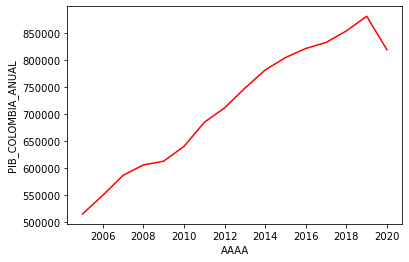

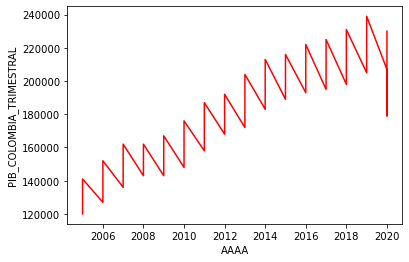

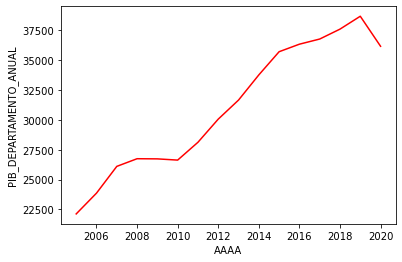

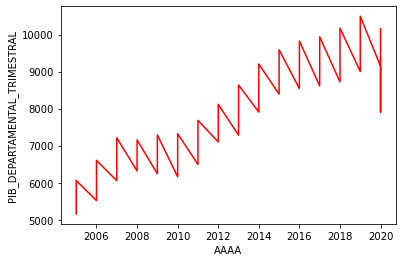

In [44]:
X_axis = df_dpto[['AAAA']]
Y_axises =['PIB_COLOMBIA_ANUAL', 'PIB_COLOMBIA_TRIMESTRAL', 'PIB_DEPARTAMENTO_ANUAL', 'PIB_DEPARTAMENTAL_TRIMESTRAL']
for Y_axis in Y_axises:
    line_plot(X_axis, df_dpto[[Y_axis]])

## PIB DIARIO Departamental Trimestral 

### Selecionando del Dataset y estableciendo las fechas diarias de cada trimestre


In [45]:
df_d = PIB_provisional.copy()
df_d.loc[:,'MM']= 0
df_d.loc[:,'DD']= 0
df_d.loc[df_d['TRIMESTRE'] == 1, 'MM'] = 3
df_d.loc[df_d['TRIMESTRE'] == 1, 'DD'] = 31
df_d.loc[df_d['TRIMESTRE'] == 2, 'MM'] = 6
df_d.loc[df_d['TRIMESTRE'] == 2, 'DD'] = 30
df_d.loc[df_d['TRIMESTRE'] == 3, 'MM'] = 9
df_d.loc[df_d['TRIMESTRE'] == 3, 'DD'] = 30
df_d.loc[df_d['TRIMESTRE'] == 4, 'MM'] = 12
df_d.loc[df_d['TRIMESTRE'] == 4, 'DD'] = 31
df_d.loc[:,'FECHA']= pd.to_datetime((df_d.AAAA * 10000 + df_d.MM * 100 + df_d.DD).apply(str), format='%Y%m%d')
df_d.loc[:,'FECHA_ORD']=df_d['FECHA'].map(datetime.toordinal)

In [46]:
df_d.head(5)

,AAAA,TRIMESTRE,DEPARTAMENTO,PIB_COLOMBIA_ANUAL,PIB_COLOMBIA_TRIMESTRAL,PIB_DEPARTAMENTO_ANUAL,APORTE,PIB_DEPARTAMENTAL_TRIMESTRAL,MM,DD,FECHA,FECHA_ORD
0,2005,1,amazonas,514853.0,120000.0,413.007446,0.000802,96.262222,3,31,2005-03-31,732036
1,2005,2,amazonas,514853.0,125000.0,413.007446,0.000802,100.273147,6,30,2005-06-30,732127
2,2005,3,amazonas,514853.0,129000.0,413.007446,0.000802,103.481888,9,30,2005-09-30,732219
3,2005,4,amazonas,514853.0,141000.0,413.007446,0.000802,113.108110,12,31,2005-12-31,732311
4,2005,1,antioquia,514853.0,120000.0,73922.532786,0.143580,17229.585793,3,31,2005-03-31,732036


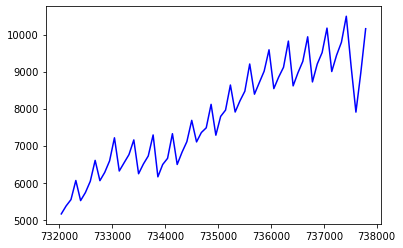

In [47]:
df_temp = df_d[(df_d['DEPARTAMENTO'] == 'atlántico')]
X = df_temp[['FECHA_ORD']]
Y = df_temp[['PIB_DEPARTAMENTAL_TRIMESTRAL']]
plt.plot(X, Y, 'b-')
plt.show()

### Estimando los nuevos valores con Regresiones 

In [48]:
from sklearn.preprocessing import PolynomialFeatures
degree= 9
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

In [49]:
output_cols = ['AAAA', 'MM', 'DD', 'FECHA', 'FECHA_ORD', 'DEPARTAMENTO', 'R2_PIB_3D','PIB_DEPARTAMENTAL_TRIMESTRAL_PRED']
dataset_pib_3dpto = pd.DataFrame(columns=output_cols)
#

LR   = ["antioquia", "quindío", "tolima"]
LR_p = ["amazonas", "bogotá d.c.", "cundinamarca", "magdalena", "meta", "risaralda", "san andrés, providencia y santa catalina (archipiélago)"]
GBR  = ["arauca", "casanare", "córdoba", "chocó", "guaviare", "huila", "putumayo", "vichada"]
SGDR = ["atlántico", "bolívar", "caquetá", "nariño", "santander", "valle del cauca", "vaupés"]

for nom_dpto in dptos:
    df_dpto = df_d[(df_d['DEPARTAMENTO']==nom_dpto)] 
    #
    X=df_dpto[['FECHA_ORD']]
    Y=df_dpto[['PIB_DEPARTAMENTAL_TRIMESTRAL']]
    #
    xTrain,xTest,yTrain,yTest= train_test_split(X,Y,test_size=0.001)
    #
    #
    #
    if (nom_dpto in LR): 
        Regresor= LinearRegression()
    elif  (nom_dpto in LR_p): 
        Regresor= make_pipeline(PolynomialFeatures(degree),LinearRegression())
    elif  (nom_dpto in GBR): 
        Regresor= GradientBoostingRegressor(random_state=0)
    elif  (nom_dpto in SGDR): 
        Regresor= make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))   
    else:
        Regressor = xgb.XGBRegressor(n_estimators=100,reg_lambda=1,gamma=0,max_depth=3)
    #
    Regresor.fit(xTrain,yTrain)
    yPred= Regresor.predict(xTrain)
    #
    #Calcular Nuevos Valores a partir del Regresor para Cada Departamento
    #
    XNew= df_predict.copy()
    XNew['FECHA'] = pd.to_datetime((XNew.AAAA * 10000 + XNew.MM * 100 + XNew.DD).apply(str), format='%Y%m%d')
    XNew['FECHA_ORD'] =XNew['FECHA'].map(datetime.toordinal)
    XNew['DEPARTAMENTO'] = nom_dpto
    XNew['R2_PIB_3D'] = r2_score(yTrain, yPred) 
    XNew['PIB_DEPARTAMENTAL_TRIMESTRAL_PRED'] = Regresor.predict(XNew[['FECHA_ORD']])
    #
    #Agrega nuevo departamento al Dataset Final
    dataset_pib_3dpto= dataset_pib_3dpto.append(XNew)  

In [50]:
dataset_pib_3dpto.head(8)

,AAAA,MM,DD,FECHA,FECHA_ORD,DEPARTAMENTO,R2_PIB_3D,PIB_DEPARTAMENTAL_TRIMESTRAL_PRED
0,2020,10,1,2020-10-01,737699,amazonas,0.860619,166.475619
1,2020,10,2,2020-10-02,737700,amazonas,0.860619,166.486314
2,2020,10,3,2020-10-03,737701,amazonas,0.860619,166.497008
3,2020,10,4,2020-10-04,737702,amazonas,0.860619,166.507702
4,2020,10,5,2020-10-05,737703,amazonas,0.860619,166.518396
5,2020,10,6,2020-10-06,737704,amazonas,0.860619,166.529089
6,2020,10,7,2020-10-07,737705,amazonas,0.860619,166.539782
7,2020,10,8,2020-10-08,737706,amazonas,0.860619,166.550474


In [51]:
dataset_pib_3dpto['R2_PIB_3D'].unique()

array([0.86061913, 0.88501444, 0.96120362, 0.8618414 , 0.88081632,
       0.82193979, 0.851959  , 0.74541069, 0.85892491, 0.9857275 ,
       0.99266132, 0.98925498, 0.98588192, 0.90226225, 0.975855  ,
       0.97802715, 0.97005438, 0.97916697, 0.97739149, 0.87025191,
       0.91677805, 0.85346945, 0.81720245, 0.99531482, 0.83935959,
       0.81812774, 0.78564822, 0.82957143, 0.88739023, 0.73504445,
       0.85666909, 0.8654059 , 0.97457925])

### Graficar Graficar por Departamento valores Reales vs Estimados

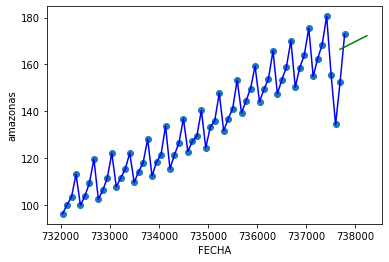

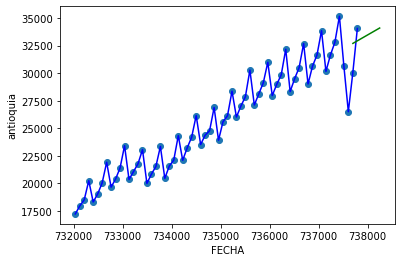

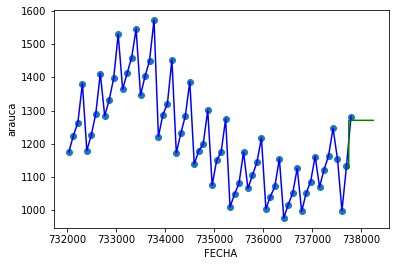

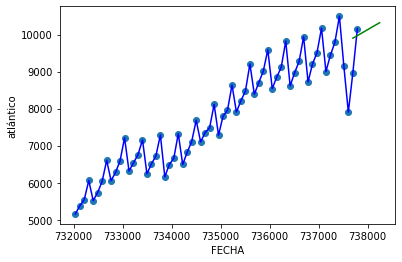

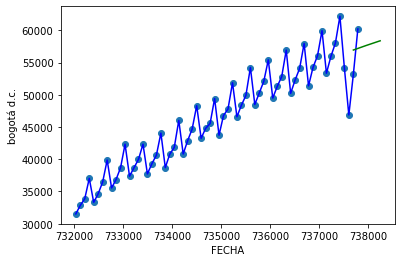

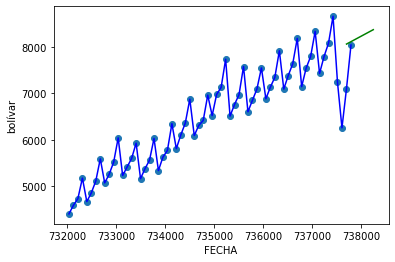

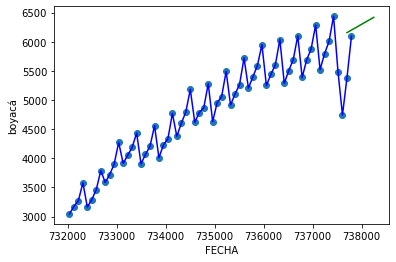

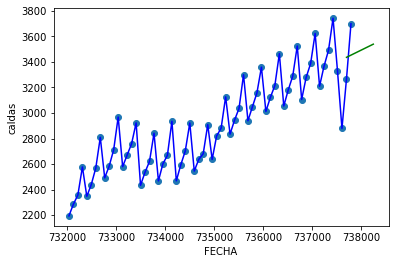

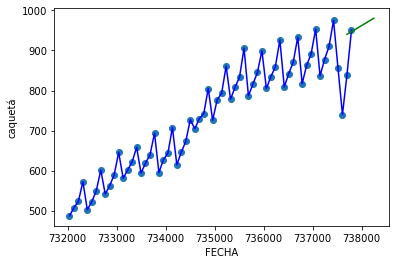

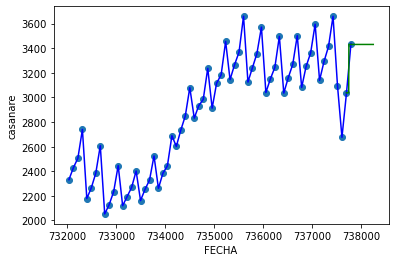

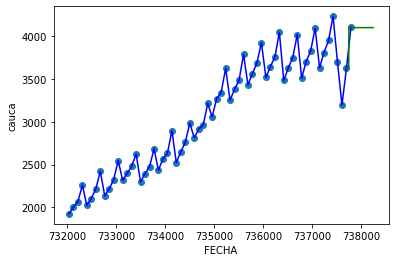

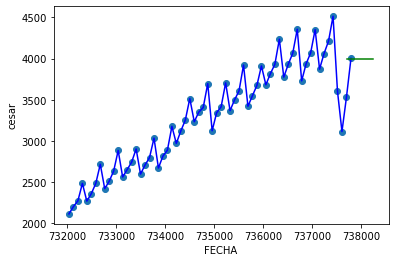

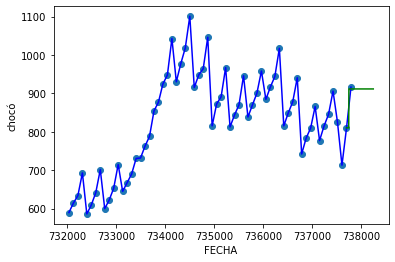

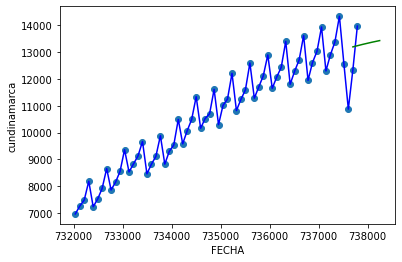

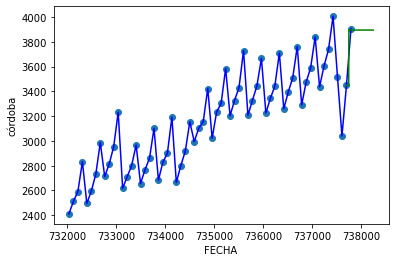

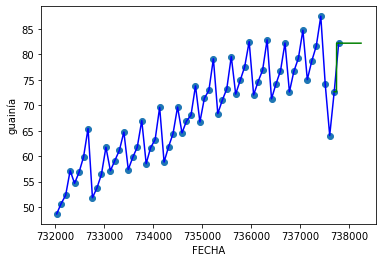

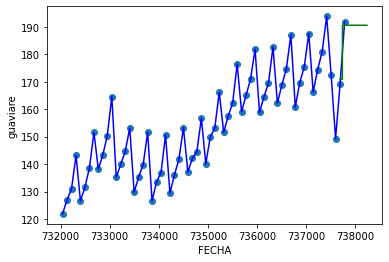

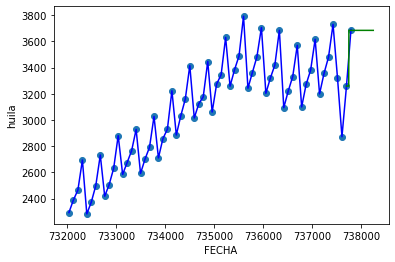

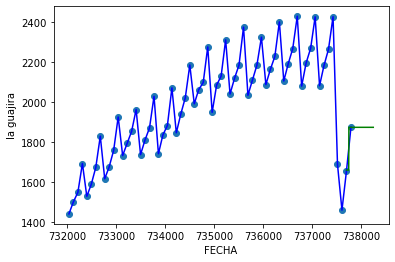

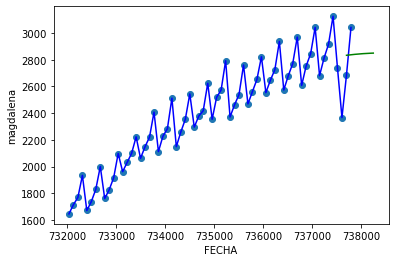

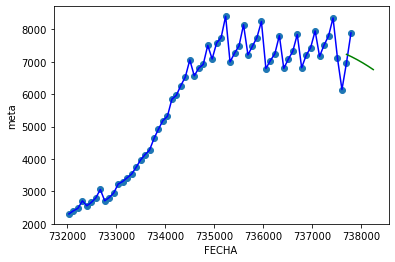

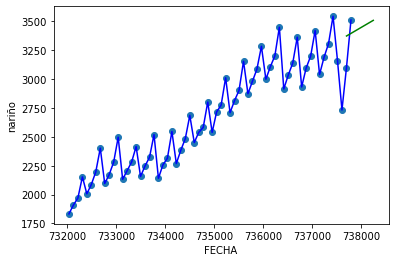

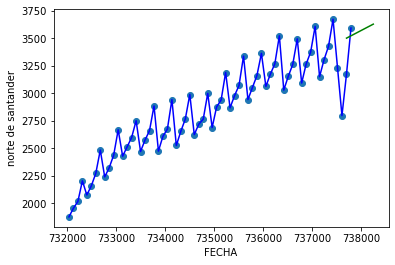

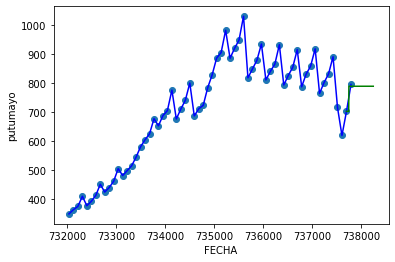

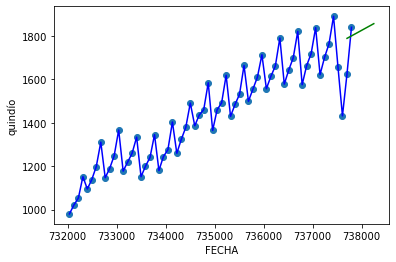

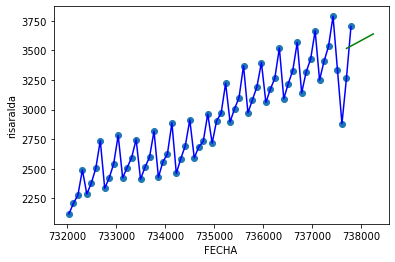

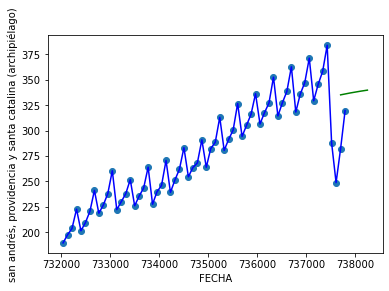

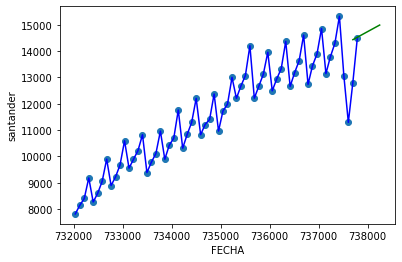

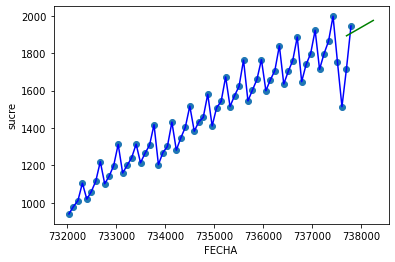

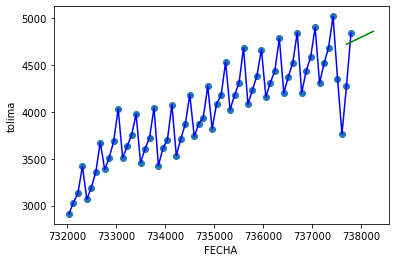

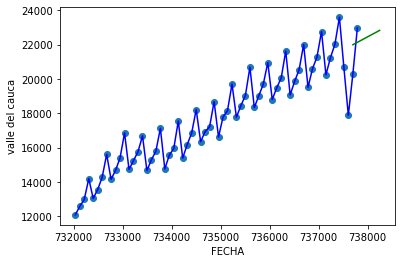

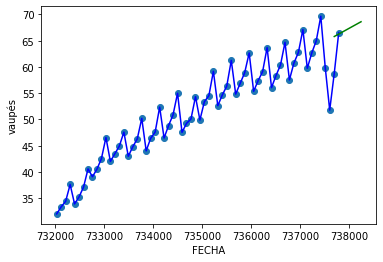

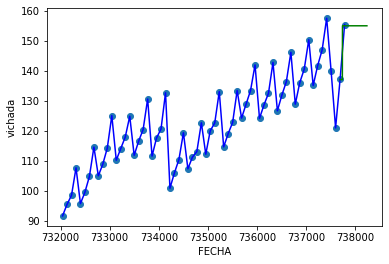

In [52]:
for K in dptos:
    d1= df_d[(df_d['DEPARTAMENTO']==K)]
    d2= dataset_pib_3dpto[(dataset_pib_3dpto['DEPARTAMENTO']==K)]
    X1= d1[['FECHA_ORD']]
    Y1= d1[['PIB_DEPARTAMENTAL_TRIMESTRAL']]
    X2= d2[['FECHA_ORD']]
    Y2= d2[['PIB_DEPARTAMENTAL_TRIMESTRAL_PRED']]
    #
    plt.xlabel("FECHA")
    plt.ylabel(K)
    #
    plt.scatter(X1, Y1)
    plt.plot(X1, Y1,'b-')
    plt.plot(X2, Y2,'g-')
    plt.show()

### Exportar Dataset Generado

In [53]:
EXPORT_COLUMNS = ['AAAA','MM','DD','FECHA','FECHA_ORD','DEPARTAMENTO','PIB_DEPARTAMENTAL_TRIMESTRAL']
REGION_COLS = ['AAAA','MM','DD','FECHA','FECHA_ORD','REGION','PIB']

PIB_raw = dataset_pib_3dpto[['AAAA','MM','DD','FECHA','FECHA_ORD','DEPARTAMENTO','PIB_DEPARTAMENTAL_TRIMESTRAL_PRED']]
PIB_raw.columns = EXPORT_COLUMNS

In [54]:
PIB_raw.head()

,AAAA,MM,DD,FECHA,FECHA_ORD,DEPARTAMENTO,PIB_DEPARTAMENTAL_TRIMESTRAL
0,2020,10,1,2020-10-01,737699,amazonas,166.475619
1,2020,10,2,2020-10-02,737700,amazonas,166.486314
2,2020,10,3,2020-10-03,737701,amazonas,166.497008
3,2020,10,4,2020-10-04,737702,amazonas,166.507702
4,2020,10,5,2020-10-05,737703,amazonas,166.518396


#### Agrupar Departamentos en Regiones

| REGION       | DEPARTAMENTOS           | | | REGION       | DEPARTAMENTOS                |
|:-------------|:------------------------|-|-|:-------------|:-----------------------------|
| Antioquia    | ANTIOQUIA               | | | Drummond     | CESAR                        |
| Arauca       | ARAUCA                  | | | Emec         | NARINO                       |
| Atlantico    | ATLANTICO               | | | GCM          | LA GUAJIRA, CESAR, MAGDALENA |
| BajoPutumayo | PUTUMAYO                | | | Guaviare     | GUAVIARE                     |
| Bolivar      | BOLIVAR                 | | | Huila        | HUILA                        |
| Boyaca       | BOYACA                  | | | Intercor     | LA GUAJIRA                   |
| Caldas       | CALDAS                  | | | Meta         | META                         |
| Cali         | VALLE DEL CAUCA         | | | Narino       | NARINO                       |
| Caqueta      | CAQUETA                 | | | NorSantander | NORTE DE SANTANDER           |
| Cartago      | VALLE DEL CAUCA         | | | Oxy          | CAQUETA                      |
| Casanare     | CASANARE                | | | Pereira      | RISARALDA                    |
| Cauca        | CAUCA                   | | | Planeta      | CORDOBA                      |
| Celsia       | VALLE DEL CAUCA, TOLIMA | | | Putumayo     | PUTUMAYO                     |
| Cerromatoso  | CORDOBA                 | | | Quindio      | QUINDIO                      |
| Choco        | CHOCO                   | | | Rubiales     | META                         |
| CiraInfanta  | SANTANDER               | | | Santander    | SANTANDER                    |
| Codensa      | BOGOTA                  | | | Tolima       | TOLIMA                       |
| CordobaSucre | CORDOBA, SUCRE          | | | TubosCaribe  | BOLIVAR                      |
| Cundinamarca | CUNDINAMARCA            | | | Tulua        | VALLE DEL CAUCA              |

In [55]:
def get_regions():
    return ['Antioquia', 'Arauca', 'Atlantico', 'BajoPutumayo', 'Bolivar', 'Boyaca', 'Caldas', 'Cali',
            'Caqueta', 'Cartago', 'Casanare', 'Cauca',  'Celsia', 'Cerromatoso', 'Choco', 'CiraInfanta',
            'Codensa', 'Cundinamarca', 'Drummond', 'Emec', 'GCM', 'Guaviare', 'Huila', 'Intercor', 'Meta', 
            'Nariño', 'NorSantander', 'Oxy', 'Pereira', 'Planeta', 'Putumayo', 'Quindio', 'Rubiales',
            'Santander', 'CordobaSucre', 'Tolima', 'TubosCaribe', 'Tulua']

In [56]:
def get_region_dependencies(region):
    regions = get_regions()
    if(region not in regions):
        return []

    map = {
        'Antioquia': ['antioquia'],
        'Arauca': ['arauca'],
        'Atlantico': ['atlántico'],
        'BajoPutumayo': ['putumayo'],
        'Bolivar': ['bolívar'],
        'Boyaca': ['boyacá'],
        'Caldas': ['caldas'],
        'Cali': ['valle del cauca'],
        'Caqueta': ['caquetá'],
        'Cartago': ['valle del cauca'],
        'Casanare': ['casanare'],
        'Cauca': ['cauca'],
        'Celsia': ['valle del cauca', 'tolima'],
        'Cerromatoso': ['córdoba'],
        'Choco': ['chocó'],
        'CiraInfanta': ['santander'],
        'Codensa': ['bogotá d.c.'],
        'Cundinamarca': ['cundinamarca'],
        'Drummond': ['cesar'],
        'Emec': ['nariño'],
        'GCM': ['la guajira',  'cesar', 'magdalena'],
        'Guaviare': ['guaviare'],
        'Huila': ['huila'],
        'Intercor': ['la guajira'],
        'Meta': ['meta'],
        'Nariño': ['nariño'],
        'NorSantander': ['norte de santander'],
        'Oxy': ['caquetá'],
        'Pereira': ['risaralda'],
        'Planeta': ['córdoba'],
        'Putumayo': ['putumayo'],
        'Quindio': ['quindío'],
        'Rubiales': ['meta'],
        'Santander': ['santander'],
        'CordobaSucre': ['córdoba', 'sucre'],
        'Tolima': ['tolima'],
        'TubosCaribe': ['bolívar'],
        'Tulua': ['valle del cauca'],
    }

    return map[region]

In [57]:
def get_region_df(df, region):
    dependencies = get_region_dependencies(region)
    
    region_filtered = df[df['DEPARTAMENTO'].isin(dependencies)]
    
    criterias = [region_filtered.DEPARTAMENTO == dependency for dependency in dependencies]
    within = [region_filtered[criteria] for criteria in criterias]
    
    region_df = within[0].copy()
    region_df[['PIB_DEPARTAMENTAL_TRIMESTRAL']] = 0;
    region_df[['DEPARTAMENTO']] = region.lower()
    
    for index in np.arange(len(within)):
        region_df[['PIB_DEPARTAMENTAL_TRIMESTRAL']] = region_df[['PIB_DEPARTAMENTAL_TRIMESTRAL']] + within[index][['PIB_DEPARTAMENTAL_TRIMESTRAL']]
    
    region_df.columns = REGION_COLS
    return region_df

In [58]:
REGIONS = get_regions()

In [59]:
regions_data = [get_region_df(PIB_raw, region) for region in REGIONS]

In [60]:
daily = pd.DataFrame(columns=REGION_COLS)

for region_df in regions_data:
    daily = daily.append(region_df, ignore_index=True)

In [61]:
daily

,AAAA,MM,DD,FECHA,FECHA_ORD,REGION,PIB
0,2020,10,1,2020-10-01,737699,antioquia,32705.152057
1,2020,10,2,2020-10-02,737700,antioquia,32707.707414
2,2020,10,3,2020-10-03,737701,antioquia,32710.262771
3,2020,10,4,2020-10-04,737702,antioquia,32712.818129
4,2020,10,5,2020-10-05,737703,antioquia,32715.373486
...,...,...,...,...,...,...,...
20781,2022,3,27,2022-03-27,738241,tulua,22829.725222
20782,2022,3,28,2022-03-28,738242,tulua,22831.258914
20783,2022,3,29,2022-03-29,738243,tulua,22832.792606
20784,2022,3,30,2022-03-30,738244,tulua,22834.326297


#### Generar Periodicidad Horaria

Esto lo haremos replicando el valor del PIB diario por region para cada hora del dia, es decir para un dia dado tendremos el mismo valor reptido 24 veces, correspondiente a las 24 horas del día.

In [62]:
hourly = pd.DataFrame(np.repeat(daily.values, 24, axis=0))
hourly.columns = daily.columns

print(f'Diario: {daily.shape}')
print(f'Horario: {hourly.shape}')

Diario: (20786, 7)
Horario: (498864, 7)


#### Generamos la Columna HH

In [63]:
hourly['HH'] = np.tile((np.arange(24) +1), len(daily))

#### Reescribimos la Columna Fecha

In [64]:
hourly_dates = hourly['FECHA'].astype(str) + ' ' + hourly['HH'].map(lambda h: str(h -1).zfill(2)) + ':00:00'
hourly['FECHA'] = hourly_dates.map(lambda dt: datetime.strptime(dt, '%Y-%m-%d %H:%M:%S'))

In [65]:
datetime.strptime('2020-10-01 01:00:00', '%Y-%m-%d %H:%M:%S')

datetime.datetime(2020, 10, 1, 1, 0)

#### Observamos los datos

In [66]:
hourly.head(24 *365 *2)

,AAAA,MM,DD,FECHA,FECHA_ORD,REGION,PIB,HH
0,2020,10,1,2020-10-01 00:00:00,737699,antioquia,32705.152057,1
1,2020,10,1,2020-10-01 01:00:00,737699,antioquia,32705.152057,2
2,2020,10,1,2020-10-01 02:00:00,737699,antioquia,32705.152057,3
3,2020,10,1,2020-10-01 03:00:00,737699,antioquia,32705.152057,4
4,2020,10,1,2020-10-01 04:00:00,737699,antioquia,32705.152057,5
...,...,...,...,...,...,...,...,...
17515,2021,4,1,2021-04-01 19:00:00,737881,arauca,1270.446965,20
17516,2021,4,1,2021-04-01 20:00:00,737881,arauca,1270.446965,21
17517,2021,4,1,2021-04-01 21:00:00,737881,arauca,1270.446965,22
17518,2021,4,1,2021-04-01 22:00:00,737881,arauca,1270.446965,23


#### Reordenamos Nuestro Dataframe para su Exportación

In [67]:
column_names = [
    'AAAA',
    'MM',
    'DD',
    'HH',
    'FECHA',
    'FECHA_ORD',
    'REGION',
    'PIB'
]
    
export_df = hourly.reindex(columns=column_names)

In [68]:
export_df

,AAAA,MM,DD,HH,FECHA,FECHA_ORD,REGION,PIB
0,2020,10,1,1,2020-10-01 00:00:00,737699,antioquia,32705.152057
1,2020,10,1,2,2020-10-01 01:00:00,737699,antioquia,32705.152057
2,2020,10,1,3,2020-10-01 02:00:00,737699,antioquia,32705.152057
3,2020,10,1,4,2020-10-01 03:00:00,737699,antioquia,32705.152057
4,2020,10,1,5,2020-10-01 04:00:00,737699,antioquia,32705.152057
...,...,...,...,...,...,...,...,...
498859,2022,3,31,20,2022-03-31 19:00:00,738245,tulua,22835.859989
498860,2022,3,31,21,2022-03-31 20:00:00,738245,tulua,22835.859989
498861,2022,3,31,22,2022-03-31 21:00:00,738245,tulua,22835.859989
498862,2022,3,31,23,2022-03-31 22:00:00,738245,tulua,22835.859989


#### Graficaremos el PIB de cada Region

In [69]:
def plot_region(df_region, region):
    X = df_region[['FECHA_ORD']]
    Y = df_region[['PIB']]
    plt.plot(X, Y, 'b-')
    plt.xlabel("FECHA")
    plt.ylabel(region)
    plt.show()

In [70]:
def plot_regions():
    for region in REGIONS:
        df_region = export_df[(export_df['REGION'] == region.lower())]
        plot_region(df_region, region)

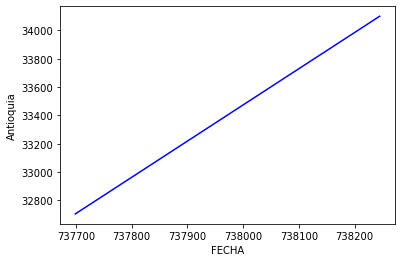

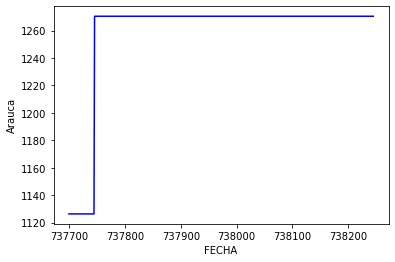

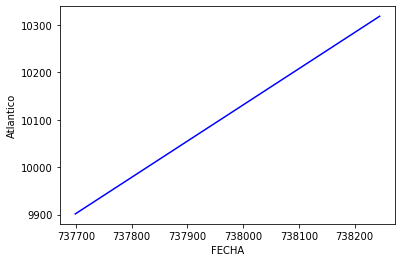

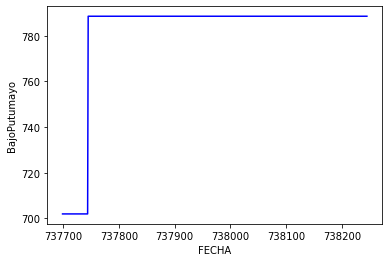

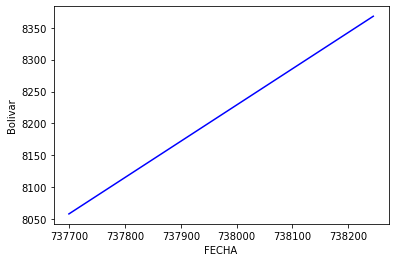

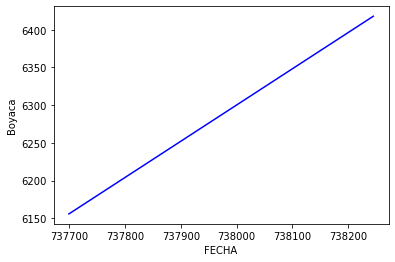

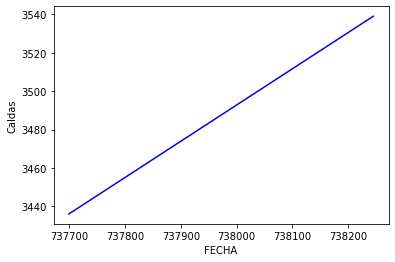

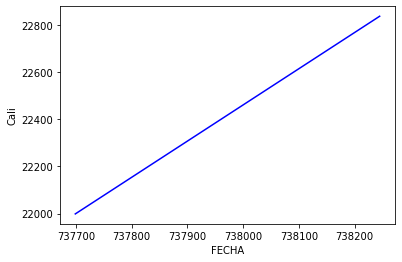

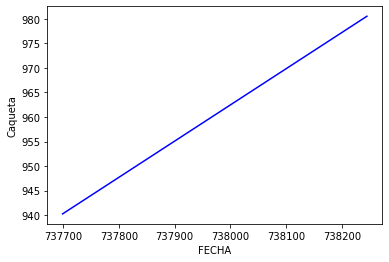

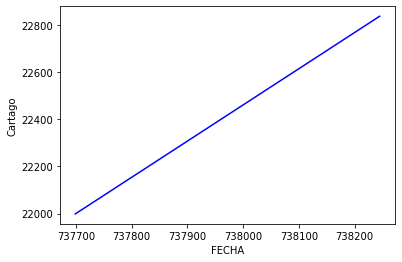

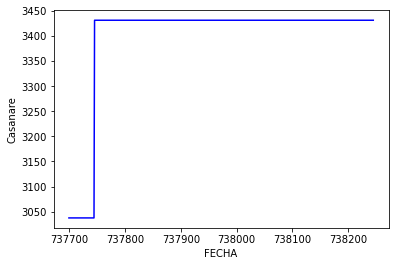

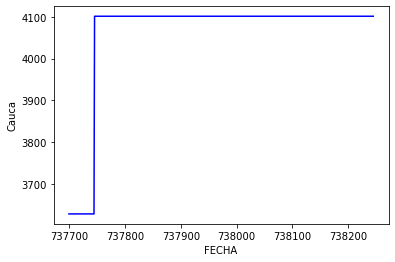

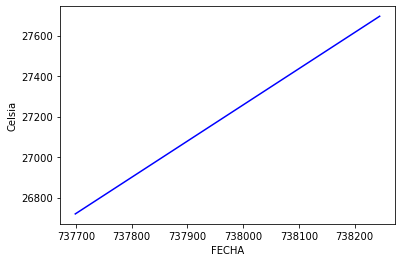

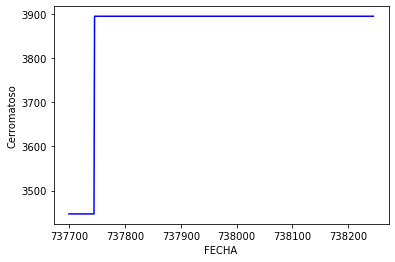

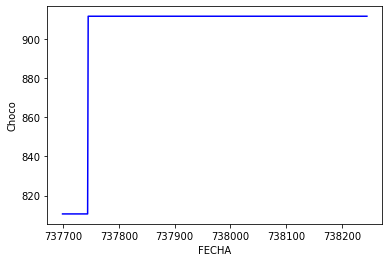

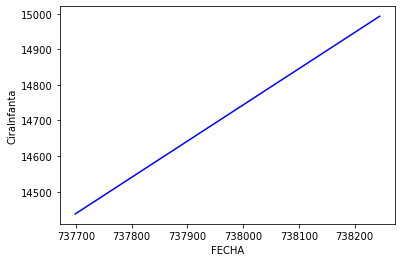

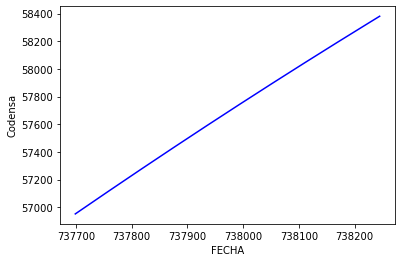

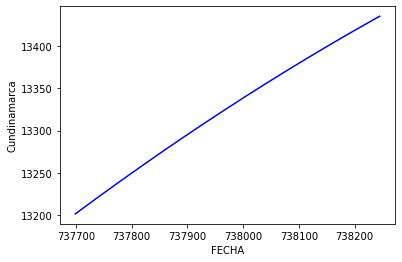

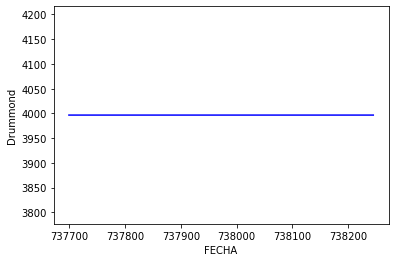

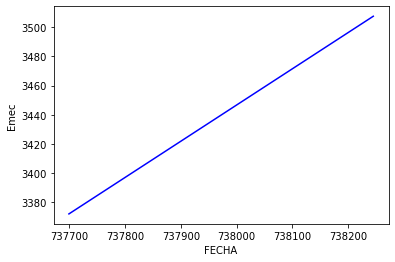

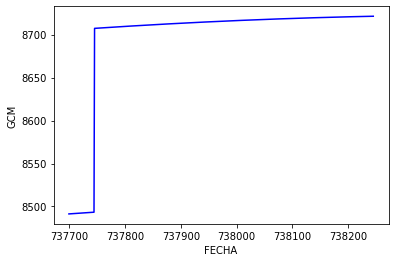

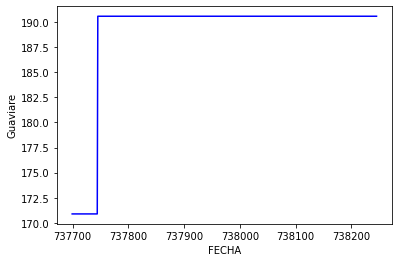

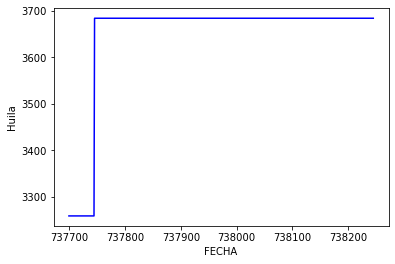

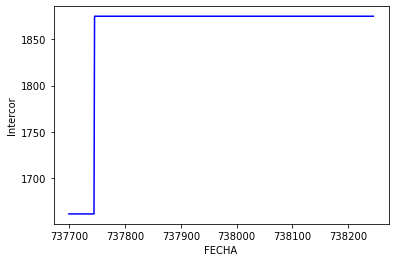

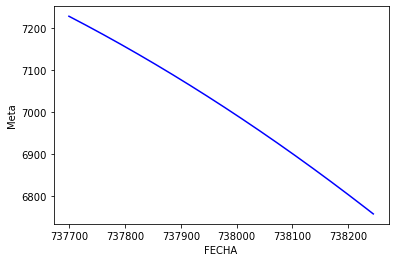

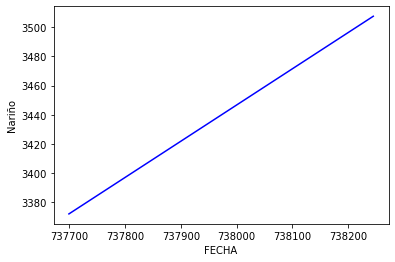

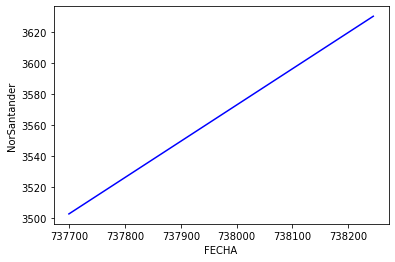

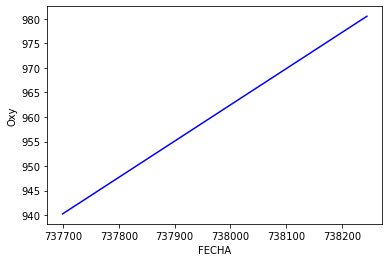

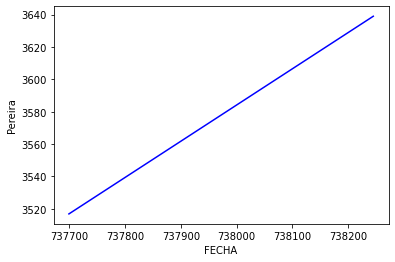

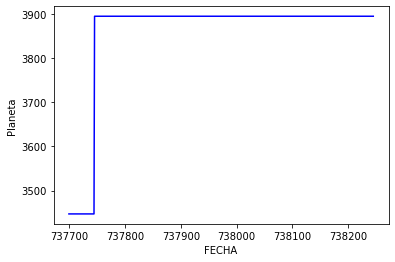

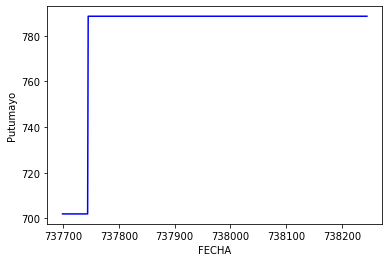

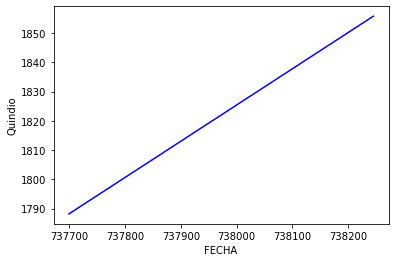

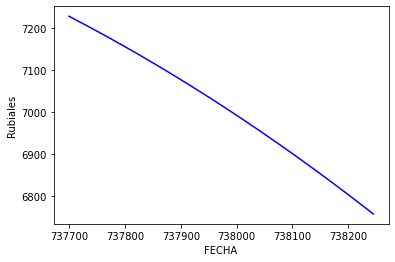

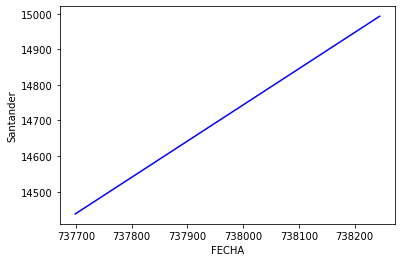

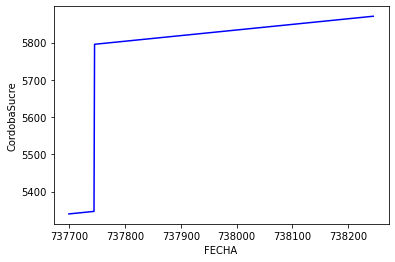

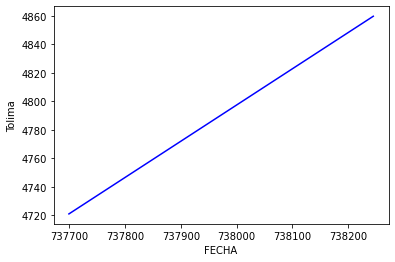

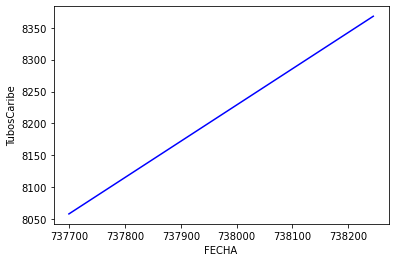

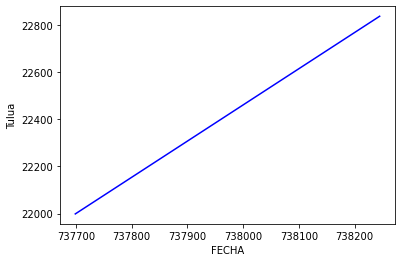

In [71]:
plot_regions()

In [72]:
export_df[(export_df['REGION'] == 'antioquia')].tail(25)

,AAAA,MM,DD,HH,FECHA,FECHA_ORD,REGION,PIB
13103,2022,3,30,24,2022-03-30 23:00:00,738244,antioquia,34097.821784
13104,2022,3,31,1,2022-03-31 00:00:00,738245,antioquia,34100.377142
13105,2022,3,31,2,2022-03-31 01:00:00,738245,antioquia,34100.377142
13106,2022,3,31,3,2022-03-31 02:00:00,738245,antioquia,34100.377142
13107,2022,3,31,4,2022-03-31 03:00:00,738245,antioquia,34100.377142
13108,2022,3,31,5,2022-03-31 04:00:00,738245,antioquia,34100.377142
13109,2022,3,31,6,2022-03-31 05:00:00,738245,antioquia,34100.377142
13110,2022,3,31,7,2022-03-31 06:00:00,738245,antioquia,34100.377142
13111,2022,3,31,8,2022-03-31 07:00:00,738245,antioquia,34100.377142
13112,2022,3,31,9,2022-03-31 08:00:00,738245,antioquia,34100.377142


#### Escribir Dataset en Periodicidad Diaria

In [73]:
daily.to_csv(f'{OUTPUT_DIR}/PIB_regional_diario.csv', index=False, encoding='utf-8', sep=";")

#### Escribir Dataset en Periodicidad Horaria

In [74]:
export_df.to_csv(f'{OUTPUT_DIR}/PIB_regional_horario.csv', index=False, encoding='utf-8', sep=";")